# Demo notebook for DDPM

### Imports

In [ ]:
import sys
import os
#sys.path.insert(1, '/kaggle/input/ddpm-git') # For Kaggle only
sys.path.append(os.path.abspath(".."))

from src.utils import CustomImageDataset, display_images
from src.schedule import CosineSchedule, LinearSchedule
from src.diffusion import Diffusion
from src.model import UNetWithPosition
from tools.train import train
from tools.sample import sample_images

from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import v2
import torchvision

### Device check

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


### Data import

In [ ]:
#data_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
batch_size = 256
img_size = 32
channels = 1

normalize = (0.5, ) if channels==1 else (0.5, 0.5, 0.5)

transform = v2.Compose([
    v2.Resize(img_size),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(normalize, normalize)
])

dataset = torchvision.datasets.FashionMNIST("./", train=True, download=True, transform=transform) # CustomImageDataset(data_dir, transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.07MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


In [4]:
max_samples = np.inf # set to np.inf for the full dataset

indices = list(range(min(len(dataset), max_samples)))

subset_dataset = Subset(dataset, indices)

dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

### Visualization of the dataset

Some images won't be displayed


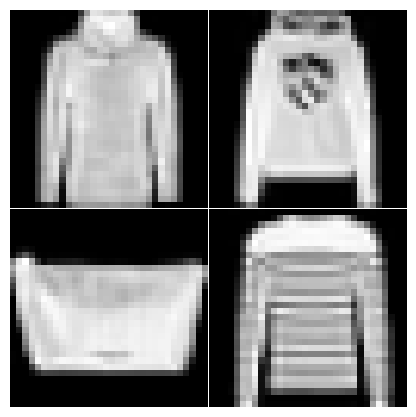

In [ ]:
img, _ = next(iter(dataloader))
img = img * 0.5 + 0.5
display_images(img, 2, 2)

### Schedule comparison

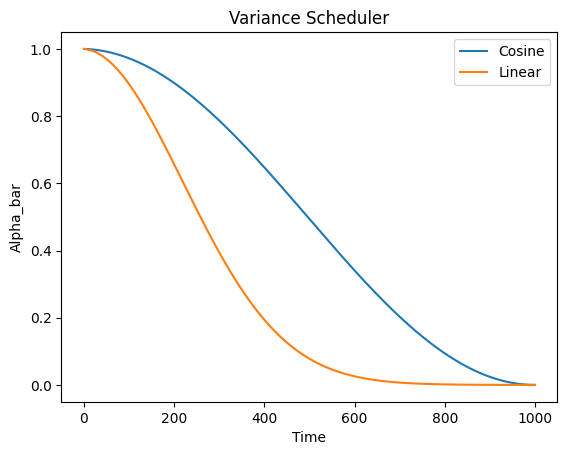

In [6]:
T = 1000
linear_schedule = LinearSchedule(T, beta_start=1e-4, beta_end=2e-2)
cosine_schedule = CosineSchedule(T, offset=0.008)

plt.title("Variance Scheduler")
plt.plot(cosine_schedule.get_alphas_bar(), label='Cosine')
plt.plot(linear_schedule.get_alphas_bar(), label='Linear')
plt.xlabel("Time")
plt.ylabel("Alpha_bar")
plt.legend()
plt.show()

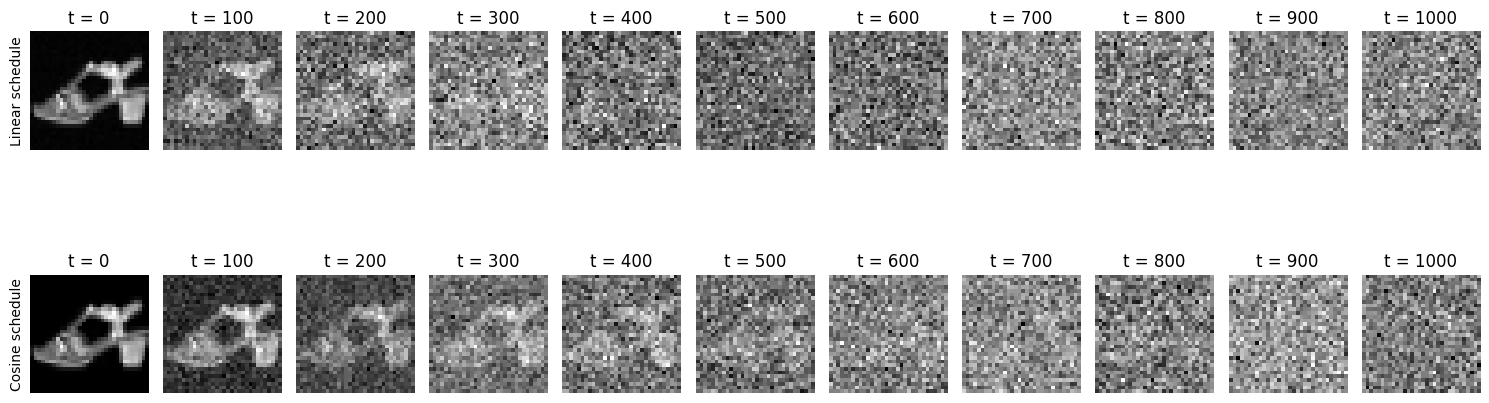

In [ ]:
diff_lin = Diffusion(linear_schedule, device)
diff_cos = Diffusion(cosine_schedule, device)

img, _ = next(iter(dataloader))
img = img * 0.5 + 0.5

img_lin = img[0].unsqueeze(0).expand(11, -1, -1, -1)
img_cos = img[0].unsqueeze(0).expand(11, -1, -1, -1)

fig, axes = plt.subplots(2, 11, figsize=(15, 6))
t  = torch.linspace(start=0, end=T, steps=11, dtype=int)

noised_images_lin = diff_lin.q(img_lin, t)[0]
noised_images_cos = diff_cos.q(img_cos, t)[0]

imgs = [noised_images_lin, noised_images_cos]

for i in range(2):
    axes[i,0].set_ylabel("Linear schedule" if i==0 else "Cosine schedule")
    for j in range(11):
        img = imgs[i][j]
        
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
    
        if img.shape[0] == 3:
            axes[i,j].imshow(np.permute_dims(img, (1, 2, 0)))
        elif img.shape[0] == 1:
            axes[i,j].imshow(np.permute_dims(img, (1, 2, 0)), cmap="gray")
        elif img.shape[2] == 3:
            axes[i,j].imshow(img)
        elif img.shape[2] == 1:
            axes[i,j].imshow(img, cmap="gray")
        
        axes[i,j].set_title(f"t = {t[j].item()}", fontsize=12)
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].spines['left'].set_visible(False)
        axes[i,j].spines['bottom'].set_visible(False)
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks([])

plt.tight_layout()
plt.show()

### Model

In [8]:
model = UNetWithPosition(in_channels=channels, out_channels=channels, base_channels=32)
model = model.to(device=device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum(p.numel() for p in model_parameters)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 36478977


### Training

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
criterion = torch.nn.MSELoss()
diff = Diffusion(cosine_schedule, device)
n_epochs = 50

train_losses, samples = train(model, diff, dataloader, n_epochs, optimizer, criterion, use_mixed_precision=True, device=device)
torch.cuda.empty_cache()

Epoch: 1 | Training Loss: 0.27487
Epoch: 2 | Training Loss: 0.10963
Epoch: 3 | Training Loss: 0.09102
Epoch: 4 | Training Loss: 0.08200
Epoch: 5 | Training Loss: 0.07713
Sampling...


100%|██████████| 1000/1000 [00:12<00:00, 83.17it/s]


Epoch: 6 | Training Loss: 0.07345
Epoch: 7 | Training Loss: 0.07032
Epoch: 8 | Training Loss: 0.06859
Epoch: 9 | Training Loss: 0.06703
Epoch: 10 | Training Loss: 0.06525
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 85.06it/s]


Epoch: 11 | Training Loss: 0.06419
Epoch: 12 | Training Loss: 0.06333
Epoch: 13 | Training Loss: 0.06183
Epoch: 14 | Training Loss: 0.06099
Epoch: 15 | Training Loss: 0.06039
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 84.91it/s]


Epoch: 16 | Training Loss: 0.05999
Epoch: 17 | Training Loss: 0.05949
Epoch: 18 | Training Loss: 0.05849
Epoch: 19 | Training Loss: 0.05832
Epoch: 20 | Training Loss: 0.05841
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 85.06it/s]


Epoch: 21 | Training Loss: 0.05721
Epoch: 22 | Training Loss: 0.05703
Epoch: 23 | Training Loss: 0.05642
Epoch: 24 | Training Loss: 0.05619
Epoch: 25 | Training Loss: 0.05536
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 84.89it/s]


Epoch: 26 | Training Loss: 0.05541
Epoch: 27 | Training Loss: 0.05490
Epoch: 28 | Training Loss: 0.05398
Epoch: 29 | Training Loss: 0.05439
Epoch: 30 | Training Loss: 0.05437
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 85.12it/s]


Epoch: 31 | Training Loss: 0.05399
Epoch: 32 | Training Loss: 0.05404
Epoch: 33 | Training Loss: 0.05372
Epoch: 34 | Training Loss: 0.05360
Epoch: 35 | Training Loss: 0.05362
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 85.29it/s]


Epoch: 36 | Training Loss: 0.05296
Epoch: 37 | Training Loss: 0.05303
Epoch: 38 | Training Loss: 0.05319
Epoch: 39 | Training Loss: 0.05263
Epoch: 40 | Training Loss: 0.05254
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 84.51it/s]


Epoch: 41 | Training Loss: 0.05225
Epoch: 42 | Training Loss: 0.05262
Epoch: 43 | Training Loss: 0.05237
Epoch: 44 | Training Loss: 0.05178
Epoch: 45 | Training Loss: 0.05102
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 84.00it/s]


Epoch: 46 | Training Loss: 0.05154
Epoch: 47 | Training Loss: 0.05141
Epoch: 48 | Training Loss: 0.05128
Epoch: 49 | Training Loss: 0.05155
Epoch: 50 | Training Loss: 0.05110
Sampling...


100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s]


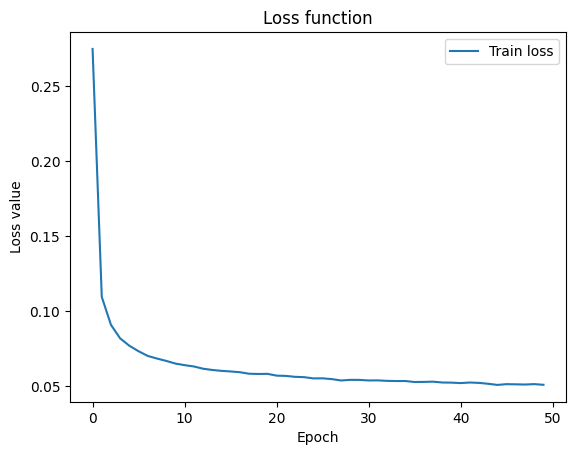

In [10]:
plt.plot(train_losses, label='Train loss')
plt.title('Loss function')
plt.xlabel('Epoch', size=10)
plt.ylabel('Loss value', size=10)
plt.legend()
plt.show()

### Samples from training

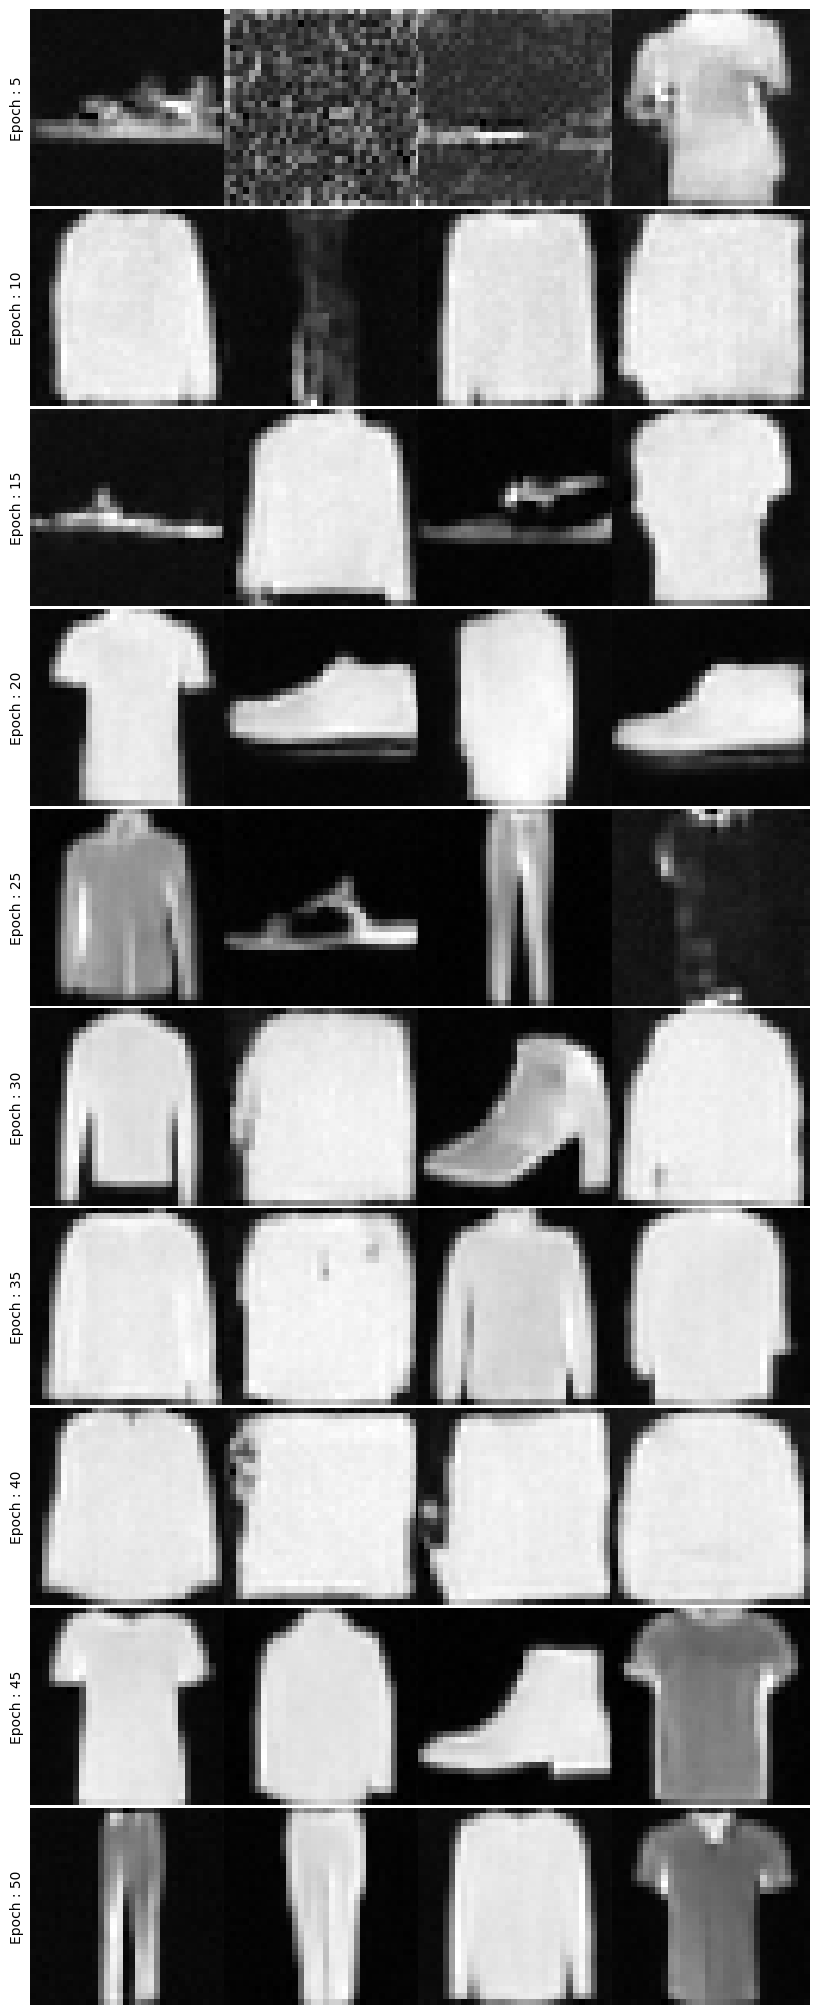

In [11]:
fig, axs = plt.subplots(len(samples), len(samples[0][1]), figsize=(8,20))
if len(samples) == 1:
    axs = np.array([axs])

for i in range(len(samples)):
    axs[i,0].set_ylabel(f"Epoch : {samples[i][0]}")
    
    for j in range(len(samples[i][1])):
        img = samples[i][1][j]
        
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()

        if img.shape[0] == 3:
            axs[i,j].imshow(np.permute_dims(img, (1, 2, 0)))
        elif img.shape[0] == 1:
            axs[i,j].imshow(np.permute_dims(img, (1, 2, 0)), cmap="gray")
        elif img.shape[2] == 3:
            axs[i,j].imshow(img)
        elif img.shape[2] == 1:
            axs[i,j].imshow(img, cmap="gray")

        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].spines['bottom'].set_visible(False)
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])

plt.tight_layout(pad=0.1)
plt.show()

### Sampling test

100%|██████████| 1000/1000 [00:20<00:00, 47.88it/s]


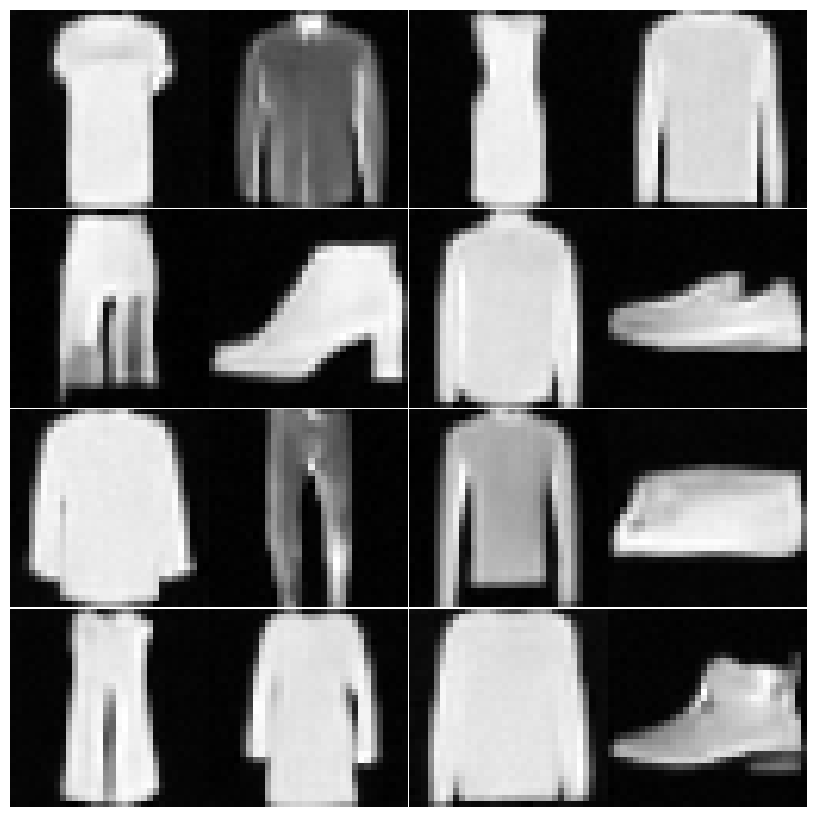

In [12]:
imgs = sample_images(model, cosine_schedule, channels, img_size, n_images=16, device=device)
display_images(imgs, 4, 4)